3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2025-03-13 07:05:41,842 - ApiComposer - Initial pipeline was fitted in 18.4 sec.
2025-03-13 07:05:41,844 - ApiComposer - Taking into account n_folds=None, estimated fit time for initial assumption is 18.4 sec.
2025-03-13 07:05:41,846 - AssumptionsHandler - Preset was changed to fast_train due to fit time estimation for initial model.
2025-03-13 07:05:41,858 - ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 1 min. Set of candidate models: ['bernb', 'dt', 'knn', 'logit', 'normalization', 'pca', 'qda', 'rf', 'scaling'].
2025-03-13 07:05:41,997 - ApiComposer - Timeout is too small for composing and is skipped because fit_time is 18.360469 sec.
2025-03-13 07:05:42,027 - ApiComposer - Hyperparameters tuning started with 1 min. timeout
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2025-03-13 07:06:05,507 - SimultaneousTuner - Initial graph: {'depth': 6, 'length': 16,

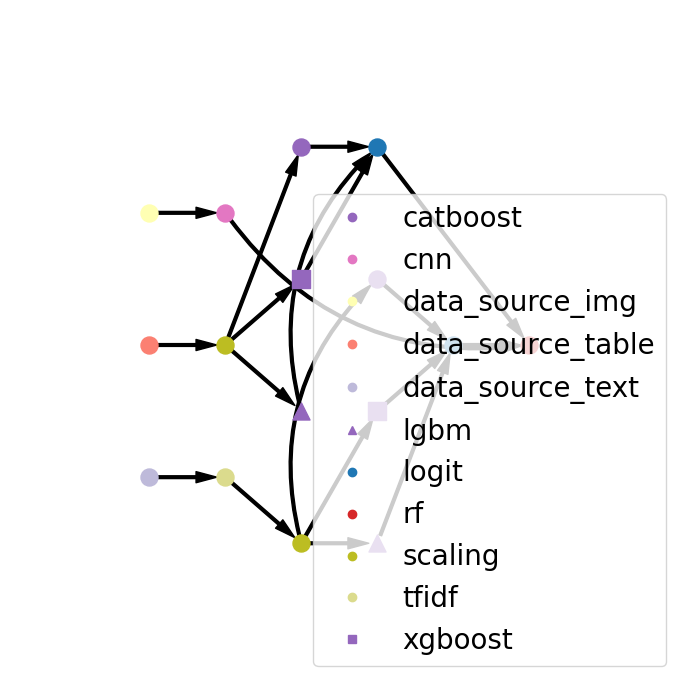

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
F1 micro for validation sample is 0.53


In [6]:
import os
from typing import Union

from sklearn.metrics import f1_score as f1

from fedot import Fedot
from fedot.core.data.data import InputData, OutputData
from fedot.core.data.data_split import train_test_data_setup
from fedot.core.data.multi_modal import MultiModalData
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import Task, TaskTypesEnum
from fedot.core.utils import fedot_project_root


def calculate_validation_metric(valid: Union[InputData, MultiModalData], pred: OutputData) -> float:
    """
    Calculates F1 score for predicted data

    :param valid: dataclass with true target
    :param pred: dataclass with model's prediction
    """

    real = valid.target
    predicted = pred.predict

    err = f1(y_true=real,
             y_pred=predicted, average='micro')

    return round(err, 2)


def prepare_multi_modal_data(files_path: str, task: Task, images_size: tuple = (128, 128)) -> MultiModalData:
    """
    Imports data from 3 different sources (table, images and text)

    :param files_path: path to data
    :param task: task to solve
    :param images_size: the requested size in pixels, as a 2-tuple of (width, height)
    :return: MultiModalData object which contains table, text and image data
    """

    path = files_path

    if not os.path.exists(path):
        raise FileNotFoundError(path)
    
    num_features=['votes', 'rating']
    text_features=['long imdb title', 'plot outline'] #['plot']

    # import of table data
    data_num = InputData.from_json_files(path, fields_to_use=num_features,
                                         label='genres', task=task, is_multilabel=True, shuffle=False)

    class_labels = data_num.target

    img_files_path = f'{files_path}/*.jpeg'
    img_path = img_files_path

    # import of image data
    data_img = InputData.from_image(images=img_path, labels=class_labels, task=task, target_size=images_size)
    # import of text data
    data_text = InputData.from_json_files(path, fields_to_use=text_features,
                                          label='genres', task=task,
                                          data_type=DataTypesEnum.text, is_multilabel=True, shuffle=False)

    data = MultiModalData({
        'data_source_img': data_img,
        'data_source_table': data_num,
        'data_source_text': data_text
    })

    return data


def run_multi_modal_pipeline(files_path: str, timeout=1, visualization=False) -> float:
    task = Task(TaskTypesEnum.classification)
    images_size = (224, 224)

    data = prepare_multi_modal_data(files_path, task, images_size)

    fit_data, predict_data = train_test_data_setup(data, shuffle=True, split_ratio=0.6)

    
    automl_model = Fedot(problem='classification', 
                metric='accuracy',
                cv_folds=None,
                preset='auto',
                seed=42,
                n_jobs=1,
                #predict_method='predict',
                timeout=timeout)
    
    pipeline = automl_model.fit(features=fit_data,
                                target=fit_data.target)

    if visualization:
        pipeline.show()

    prediction = pipeline.predict(predict_data, output_mode='labels')

    err = calculate_validation_metric(predict_data, prediction)

    print(f'F1 micro for validation sample is {err}')

    return pipeline, predict_data, prediction, err

pipeline, predict_data, prediction, err = run_multi_modal_pipeline(files_path='../../datasets-local/multimodal', visualization=True)